In [21]:
#importing all the required libraries
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd

In [22]:
# reading the 3D Points Data and storing it in pcd file
pcd = o3d.io.read_point_cloud(r"C:\Users\Radhakanta Koner\Desktop\set2modelclean.ply")
o3d.visualization.draw_geometries([pcd])

In [23]:
# Removing the plane surface on which rock stays, (ROCKS ARE IN GREY COLOR AND SURFACE IS IN RED COLOR)
# We would like to study on 3d rock cloud by removing plane surface
plane_model, inliers = pcd.segment_plane(distance_threshold=0.05, ransac_n=3, num_iterations=1000)
inlier_cloud = pcd.select_by_index(inliers)
rock_cloud = pcd.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1, 0, 0])
rock_cloud.paint_uniform_color([0.6, 0.6, 0.6])
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
o3d.visualization.draw_geometries([inlier_cloud, rock_cloud])


In [24]:
# Creating Labels for each individual Cluster i.e 0,1,2 for Each rock (i.e total 3 rock clusters)

labels = np.array(rock_cloud.cluster_dbscan(eps=0.07, min_points= 50 ))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0 
rock_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])
max_label 

62

In [25]:
o3d.visualization.draw_geometries([rock_cloud])

In [27]:
rock_cloud # no of whole 3d points of rock_cloud

PointCloud with 792306 points.

In [28]:
with o3d.utility.VerbosityContextManager(
o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(rock_cloud.cluster_dbscan(eps=0.07, min_points=50, print_progress=True))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 63


In [29]:
if len(labels) != 0:
    # Get biggest cluster label
    max_label = labels.max() + 1


In [30]:
max_label = labels.max() + 1
# print(max_label)
for i in range(max_label):
    id = np.where(labels==i)[0]
    pcd_i = rock_cloud.select_by_index(id)
    #o3d.visualization.draw_geometries([pcd_i])
    x = str(i)
    
    #saving individual rocks, cube into different ply point cloud files.
    #o3d.io.write_point_cloud(r"C:\Users\Radhakanta Koner\Desktop\3DFM" + x + ".ply", pcd_i)

In [31]:
for i in range(max_label):
    id = np.where(labels==i)[0]
    pcd_i = pcd.select_by_index(id)
    hull, _ = pcd_i.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((1, 0, 0))
    #o3d.visualization.draw_geometries([pcd_i, hull_ls ])

In [32]:
from __future__ import division
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import sys  # maxint
from mpl_toolkits.mplot3d import Axes3D
from math import *
%matplotlib inline
import matplotlib as mpl

In [33]:
def minBoundingRect(hull_points_3d,Epsilon):
    a=[]
    boxes=[]
    count = 0
    # Test each angle to find bounding box with smallest area
    min_bbox = (0, 0, sys.maxsize, 0, 0, 0, 0, 0, 0, 0, 0, 0) 
    # rot_angle1, rot_angle2, volume, width, height, depth, min_x, max_x, min_y, max_y, max_z, min_z

    angi=np.arange(0.0, 90, Epsilon)

    for iDeg in (angi):
        boxes.append([])
        angj=np.arange(0.0, 180, Epsilon)
        for jDeg in (angj):
            
            i=deg2rad(iDeg)
            j=deg2rad(jDeg)
            
            #Rotation Matrix = Rx * Rz
            R = array([ [ math.cos(i),                                       -math.cos(i-(math.pi/2)),              0],
                        [ math.cos(j)*math.cos(i-(math.pi/2))  ,             math.cos(j)*math.cos(i), -math.cos(j-(math.pi/2)) ],
                        [ math.cos(i-(math.pi/2)) * math.cos(j-(math.pi/2)), math.cos(j-(math.pi/2))*math.cos(i),  math.cos(j) ] ])

            #             OR
            #             Rx = array([ [ 1,0,0],
            #                          [ 0, math.cos(j), -math.cos(j-(math.pi/2)) ], 
            #                          [ 0, math.cos(j-(math.pi/2)), math.cos(j) ] ])
            #             Rz = array([ [ math.cos(i), -math.cos(i-(math.pi/2)), 0 ], 
            #                          [ math.cos(i-(math.pi/2)), math.cos(i) , 0 ], 
            #                          [ 0,0,1]])
            #             R = matmul(Rx,Rz)
                        
            # Apply this rotation to convex hull points
            rot_points = matmul((hull_points_3d), R )

            a.append(rot_points)

            # Find min/max x,y points
            min_x = nanmin(rot_points[:,0], axis=0)
            max_x = nanmax(rot_points[:,0], axis=0)
            min_y = nanmin(rot_points[:,1], axis=0)
            max_y = nanmax(rot_points[:,1], axis=0)
            min_z = nanmin(rot_points[:,2], axis=0)
            max_z = nanmax(rot_points[:,2], axis=0)
            
           # Calculate height/width/area of this bounding rectangle
            width = max_x - min_x
            height = max_y - min_y
            depth = max_z-min_z
            Volume = width * height * depth

            boxes[count].append(Volume)

            # Store the smallest rect found first (a simple convex hull might have 2 answers with same area)
            if (Volume < min_bbox[2]):
                min_bbox = ( i,j, Volume, width, height, depth, min_x, max_x, min_y, max_y, min_z, max_z )
        count=count+1
        
        
        
        # Re-create rotation matrix for smallest rect
    i = min_bbox[0]
    j = min_bbox[1]
    R = array([ [ math.cos(i),                                       -math.cos(i-(math.pi/2)),              0],
                [ math.cos(j)*math.cos(i-(math.pi/2))  ,             math.cos(j)*math.cos(i), -math.cos(j-(math.pi/2)) ],
                [ math.cos(i-(math.pi/2)) * math.cos(j-(math.pi/2)), math.cos(j-(math.pi/2))*math.cos(i),  math.cos(j)             ] ])

    # Project convex hull points onto rotated frame
    rot_points = matmul((hull_points_3d), R )
    
    
    # min/max x,y points are against baseline
    min_x = min_bbox[6]
    max_x = min_bbox[7]
    min_y = min_bbox[8]
    max_y = min_bbox[9]
    min_z = min_bbox[10]
    max_z = min_bbox[11]

    # Calculate center point and project onto rotated frame
    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_z = (min_x + max_x)/2
    center_point = matmul(linalg.inv(R) , [ center_x, center_y, center_z])
    #print ("Bounding box center point: \n", center_point)

    # Calculate corner points and project onto rotated frame
    corner_points = zeros( (16,3) ) # empty 2 column array
    corner_points[0] = matmul(  (R) ,[ min_x, min_y ,min_z ])
    corner_points[1] = matmul(  (R), [ max_x, min_y ,min_z ])
    corner_points[2] = matmul(  (R), [ max_x, max_y ,min_z ])
    corner_points[3] = matmul(  (R), [ min_x, max_y ,min_z ])
    corner_points[4] = matmul(  (R), [ min_x, min_y ,min_z ])
    
    corner_points[5] = matmul( (R), [ min_x, min_y ,max_z ])
    corner_points[6] = matmul( (R), [ max_x, min_y ,max_z ])
    corner_points[7] = matmul( (R), [ max_x, max_y ,max_z ])
    corner_points[8] = matmul( (R), [ min_x, max_y ,max_z ])
    corner_points[9] = matmul( (R), [ min_x, min_y ,max_z ])

    corner_points[10] = matmul( (R), [ max_x, min_y ,max_z ])
    corner_points[11] = matmul( (R), [ max_x, min_y ,min_z ])
    
    corner_points[12] = matmul( (R), [ max_x, max_y ,min_z ] )
    corner_points[13] = matmul( (R), [ max_x, max_y ,max_z ])

    corner_points[14] = matmul( (R), [ min_x, max_y ,max_z ])
    corner_points[15] = matmul( (R), [ min_x, max_y ,min_z ])

    return ( i, j, min_bbox[2], min_bbox[3], min_bbox[4], min_bbox[5], center_point, corner_points,a,boxes,rot_points) 
    # rot_angle, area, width, height, center_point, corner_points


            

In [34]:
xyz_load = np.asarray(hull_ls.points)

Minimum Volume bounding box:
Rotation angles:
Along z axes:  0.19198621771937624 rad  ( 11.0 deg )
Along x axes:  2.993239667170275 rad  ( 171.5 deg )
Width: 6.97547348958034  Height: 4.783194818867851  Depth: 0.45569222145366695   Volume: 15.204193140283676
Center point: 
 [ 5.78027757 -3.0828367  -6.61929482]
Corner points: 
 [[ 2.63030320e+00  6.59023719e-02  7.26981814e+00]
 [ 9.47761760e+00 -1.25046102e+00  7.46654996e+00]
 [ 8.56494100e+00 -5.89420110e+00  8.16056157e+00]
 [ 1.71762661e+00 -4.57783771e+00  7.96382974e+00]
 [ 2.63030320e+00  6.59023719e-02  7.26981814e+00]
 [ 2.63030320e+00 -1.45322699e-03  6.81913130e+00]
 [ 9.47761760e+00 -1.31781662e+00  7.01586313e+00]
 [ 8.56494100e+00 -5.96155670e+00  7.70987473e+00]
 [ 1.71762661e+00 -4.64519331e+00  7.51314291e+00]
 [ 2.63030320e+00 -1.45322699e-03  6.81913130e+00]
 [ 9.47761760e+00 -1.31781662e+00  7.01586313e+00]
 [ 9.47761760e+00 -1.25046102e+00  7.46654996e+00]
 [ 8.56494100e+00 -5.89420110e+00  8.16056157e+00]
 [ 8.56

Text(0.5, 0.92, 'Minimum Volume Bounding Box')

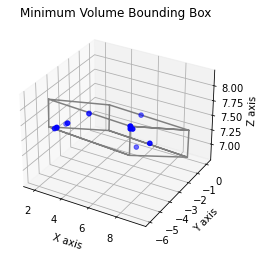

In [35]:
Epsilon = 0.5 #Angle Variations for bounding boxes
(rot_angle1, rot_angle2, Volume, width, height, depth, center_point, corner_points,a,boxes,
 rot_points) = minBoundingRect(xyz_load,Epsilon)

print ("Minimum Volume bounding box:")
print ("Rotation angles:")
print("Along z axes: ", rot_angle1, "rad  (", rot_angle1*(180/math.pi), "deg )")
print("Along x axes: ", rot_angle2, "rad  (", rot_angle2*(180/math.pi), "deg )")
print ("Width:", width, " Height:", height, " Depth:", depth, "  Volume:", Volume)
print ("Center point: \n", center_point) # numpy array
print ("Corner points: \n", corner_points, "\n")  # numpy array

fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(corner_points[:, 0], corner_points[:, 1], corner_points[:, 2], 'gray')
ax.scatter(xyz_load[:, 0], xyz_load[:, 1], xyz_load[:, 2], s=20, c='b', zorder=10)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Minimum Volume Bounding Box')

In [36]:
Epsilon = 0.5
for i in range(max_label):
    id = np.where(labels==i)[0]
    pcd_i = pcd.select_by_index(id)
    hull, _ = pcd_i.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    hull_ls.paint_uniform_color((1, 0, 0))
    xyz_load = np.asarray(hull_ls.points)
    (rot_angle1, rot_angle2, Volume, width, height, depth, center_point, corner_points,a,boxes,rot_points) = minBoundingRect(xyz_load,Epsilon)
    Dimension =  min(width,height,depth)
    #print ("Minimum Volume bounding box:", i )
    print ("Rock_No:", i , " |Width(cm):", "{:.2f}".format(width), "|Height(cm):", "{:.2f}".format(height) , "|Depth(cm):", "{:.2f}".format(depth),"|Small Dimension(cm):" ,"{:.2f}".format(Dimension), "|Weight(gms):",  "{:.2f}".format(Volume))
    
    

Rock_No: 0  |Width(cm): 1.88 |Height(cm): 8.68 |Depth(cm): 7.41 |Small Dimension(cm): 1.88 |Weight(gms): 121.05
Rock_No: 1  |Width(cm): 1.89 |Height(cm): 8.68 |Depth(cm): 7.41 |Small Dimension(cm): 1.89 |Weight(gms): 121.59
Rock_No: 2  |Width(cm): 1.90 |Height(cm): 8.67 |Depth(cm): 7.41 |Small Dimension(cm): 1.90 |Weight(gms): 122.09
Rock_No: 3  |Width(cm): 1.86 |Height(cm): 8.67 |Depth(cm): 7.41 |Small Dimension(cm): 1.86 |Weight(gms): 119.64
Rock_No: 4  |Width(cm): 1.16 |Height(cm): 8.68 |Depth(cm): 7.40 |Small Dimension(cm): 1.16 |Weight(gms): 74.65
Rock_No: 5  |Width(cm): 0.82 |Height(cm): 8.64 |Depth(cm): 7.23 |Small Dimension(cm): 0.82 |Weight(gms): 50.98
Rock_No: 6  |Width(cm): 1.09 |Height(cm): 8.58 |Depth(cm): 7.15 |Small Dimension(cm): 1.09 |Weight(gms): 66.96
Rock_No: 7  |Width(cm): 0.97 |Height(cm): 8.66 |Depth(cm): 7.40 |Small Dimension(cm): 0.97 |Weight(gms): 62.25
Rock_No: 8  |Width(cm): 1.12 |Height(cm): 8.37 |Depth(cm): 7.39 |Small Dimension(cm): 1.12 |Weight(gms): 69.